In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST digits (28x28 grayscale images)
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # shape (60000, 28, 28, 1)

print("Training data shape:", x_train.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (60000, 28, 28, 1)


**Generator takes random noise (100 numbers) → produces fake digit image (28x28).**

In [ ]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((7, 7, 256)),

        layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='sigmoid')
    ])
    return model

generator = build_generator()
generator.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

**Discriminator takes image (real/fake) → outputs real/fake probability.**

In [ ]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28, 28, 1]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

discriminator = build_discriminator()
discriminator.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Binary cross-entropy loss (for real vs fake classification)
cross_entropy = tf.keras.losses.BinaryCrossentropy()

# Optimizers for both Generator & Discriminator
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


# One training step: update Generator & Discriminator
@tf.function
def train_step(images):
    # 1. Sample random noise (latent vector) to feed the generator
    noise = tf.random.normal([BATCH_SIZE, 100])

    # 2. Record operations for automatic differentiation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        # --------------------
        # Forward pass
        # --------------------

        # Generator creates fake images from random noise
        generated_images = generator(noise, training=True)

        # Discriminator evaluates real images (should predict 1 / real)
        real_output = discriminator(images, training=True)

        # Discriminator evaluates fake images (should predict 0 / fake)
        fake_output = discriminator(generated_images, training=True)


        # --------------------
        # Loss functions
        # --------------------

        # Generator wants Discriminator to believe fake images are real (label = 1)
        gen_loss = cross_entropy(tf.ones_like(fake_output), fake_output)

        # Discriminator tries to classify correctly:
        # - real images as 1
        # - fake images as 0
        disc_loss = (
            cross_entropy(tf.ones_like(real_output), real_output) +  # real -> 1
            cross_entropy(tf.zeros_like(fake_output), fake_output)   # fake -> 0
        )


    # --------------------
    # Compute gradients
    # --------------------

    # Gradient of Generator loss wrt Generator weights
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    # Gradient of Discriminator loss wrt Discriminator weights
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)


    # --------------------
    # Apply gradients (update weights)
    # --------------------

    # Update Generator weights to fool Discriminator better
    generator_optimizer.apply_gradients(
        zip(gradients_of_generator, generator.trainable_variables)
    )

    # Update Discriminator weights to distinguish better
    discriminator_optimizer.apply_gradients(
        zip(gradients_of_discriminator, discriminator.trainable_variables)
    )


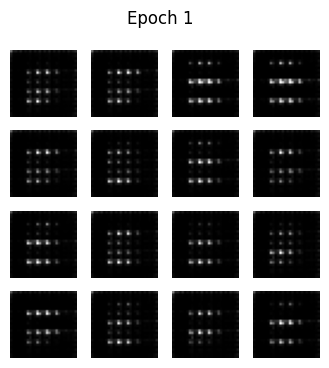

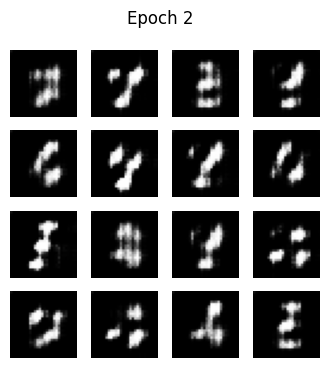

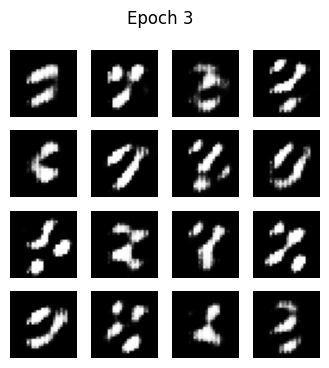

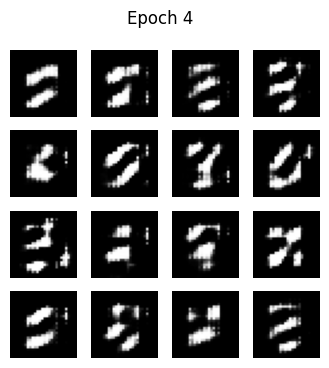

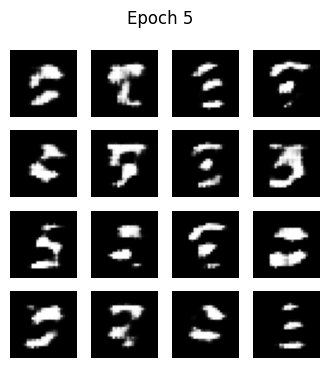

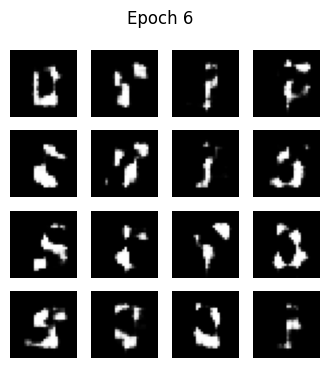

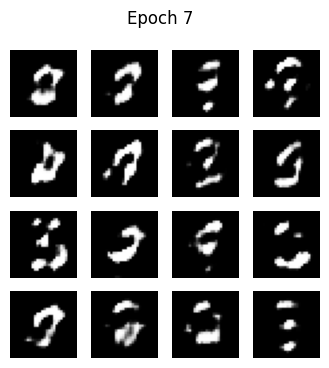

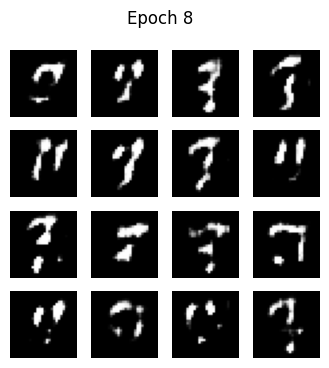

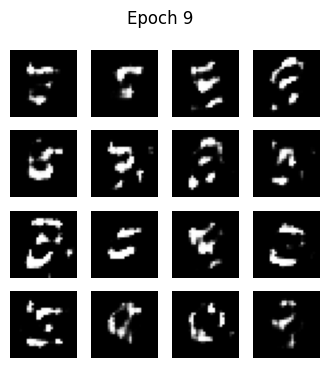

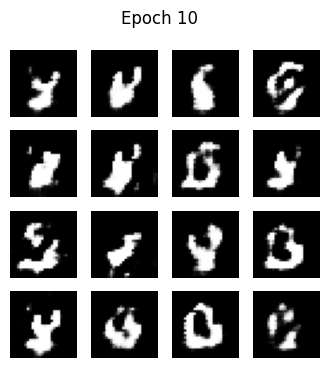

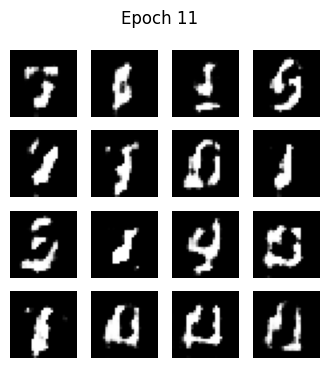

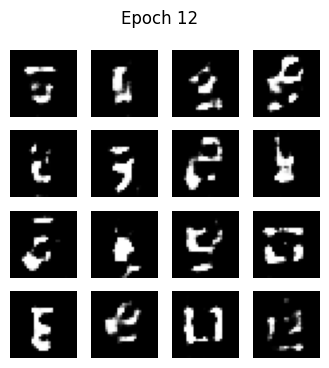

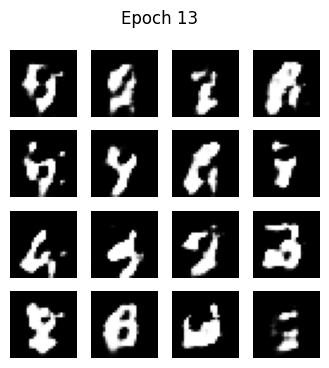

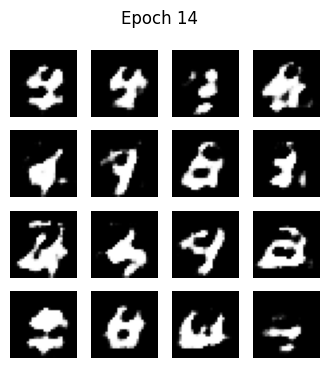

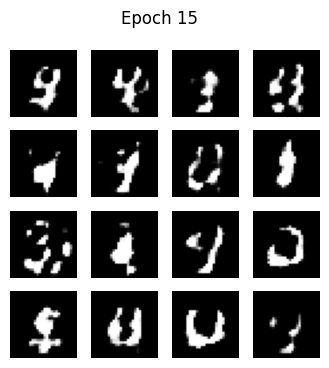

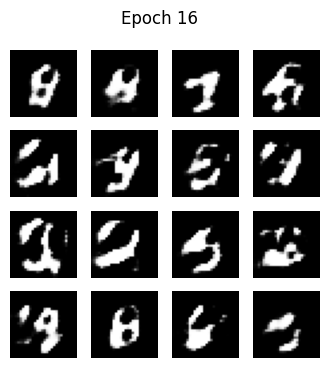

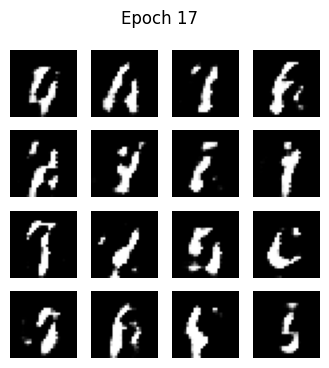

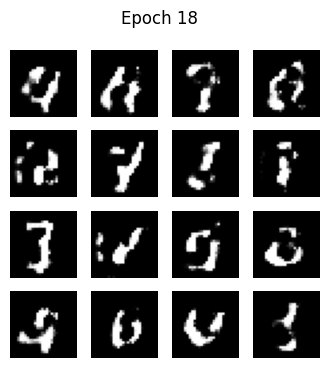

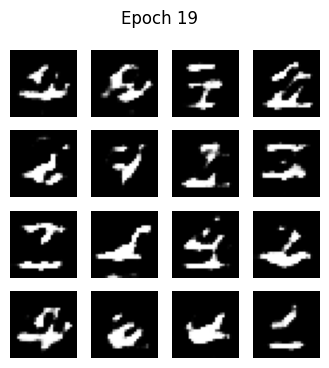

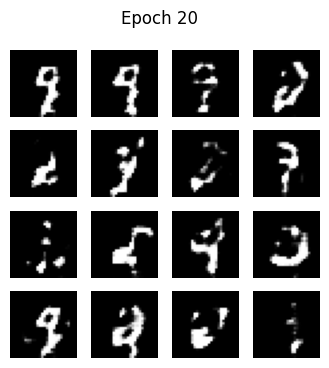

In [ ]:
BATCH_SIZE = 256
EPOCHS = 20
seed = tf.random.normal([16, 100])  # for generating sample images

dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(60000).batch(BATCH_SIZE)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.suptitle(f"Epoch {epoch}")
    plt.show()

for epoch in range(1, EPOCHS+1):
    for image_batch in dataset:
        train_step(image_batch)
    generate_and_save_images(generator, epoch, seed)

**Pre - trained model**

In [ ]:
!pip install pytorch-lightning lightning-bolts

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from pl_bolts.models.gans import GAN
from pl_bolts.datamodules import MNISTDataModule
from pytorch_lightning import Trainer

# 1. Create a GAN model
# MNIST images are grayscale (1 channel) and 28x28 pixels
model = GAN(input_channels=1, input_height=28, input_width=28)

# 2. Load MNIST dataset (pl_bolts has a ready-made DataModule for it)
datamodule = MNISTDataModule(batch_size=32)

# 3. Create a Trainer
trainer = Trainer(max_epochs=5, accelerator="cpu")
# If you have GPU, use: accelerator="gpu", devices=1

# 4. Train the GAN
trainer.fit(model, datamodule=datamodule)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/configuration_validator.py:106: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
100%|██████████| 9.91M/9.91M [00:00<00:00, 18.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.66

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchvision/datasets/mnist.py:143: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(img.numpy(), mode="L")
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:32: DeprecationWarning: This property will be removed in 2.0.0. Use `Metric.updated_called` instead.
  return fn(*args, **kwargs)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


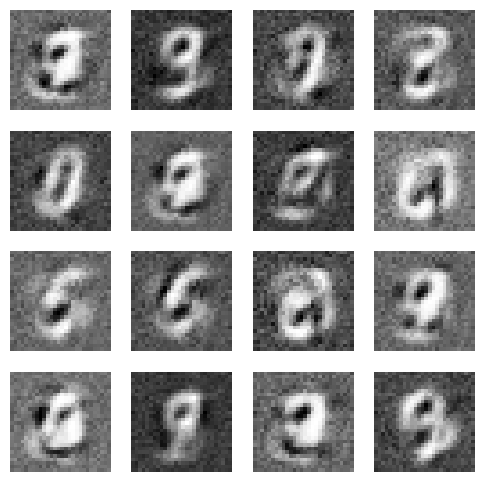

In [ ]:
import torch
import matplotlib.pyplot as plt

# Put the generator in evaluation mode
model.generator.eval()

# 1. Generate random noise (e.g., 16 samples of 100-dim noise vectors)
z = torch.randn(16, model.hparams.latent_dim)

# 2. Generate fake images
with torch.no_grad():
    fake_images = model.generator(z)

# 3. Plot them (MNIST images are 28x28 grayscale)
fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(fake_images[i].squeeze().cpu().numpy(), cmap="gray")
    ax.axis("off")
plt.show()


In [ ]:
!pip install diffusers transformers accelerate

In [ ]:


from diffusers import StableDiffusionPipeline
import torch

pipe = StableDiffusionPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    torch_dtype=torch.float16
).to("cuda")

image = pipe("A futuristic city skyline at sunset").images[0]
image.show()
